In [1]:
import numpy as np
import mne
import os, sys
import re
import pandas as pd

In [2]:
from snn_lib.neuron_models.leaky_intergrate_and_fire_model import *
from snn_lib.synapse_models.delay_connection import *
from snn_lib.synapse_models.exponential_synapse import *
from snn_lib.neuron_models.point_process_model import *
from snn_lib.connections.full_connection import *
from snn_lib.connections.one_to_one_connection import OneToOneConnection
from snn_lib.neuron_models.fixed_spike_train_neuron_model import FixedSpikeTrainNeuronModel
from snn_lib.monitors.neuron_monitors import NeuronOutputMonitor, NeuronMembranePotentialMonitor
from snn_lib.monitors.synapse_monitors import *
import numpy as np
from microstates.main.eeg_recording import *
from snn_lib.plots.snn_recorder_plot import plot_neuron_record
from snn_lib.connections.custom_connection import CustomConnection

## Load Dataset

In [3]:
eeg_raw = mne.io.read_raw('C:/Users/Micro/Desktop/MainResearchProjects/eeg-language/data/dataset1/Raw_EDF_Files/p10_Record1.edf') #list(eeg_raw.values())[0]

Extracting EDF parameters from C:\Users\Micro\Desktop\MainResearchProjects\eeg-language\data\dataset1\Raw_EDF_Files\p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
SOP = 30 * 60 # seizure occurrance period (s)
SPH = 5 * 60 # seizure prediction horizon

In [5]:
freq = 500
total_length = freq * SOP

In [6]:
data = eeg_raw.get_data().T

In [7]:
# Clip the data. (Extract the seizure occurrance period)

record_start = (5, 36, 39) # hour, minute, seconds.

seizure1 = (7, 36, 38)  # hour, minute, seconds.
seizure1_start = ((seizure1[0] - record_start[0]) * 3600 + (seizure1[1] - record_start[1]) * 60 + (seizure1[2] - record_start[2])) * freq
seizure1_length = (60 * 7 + 25) * freq
seizure1_end = seizure1_start + seizure1_length

# clip
seizure_mid = (seizure1_start + seizure1_end) // 2
clip_left = (seizure_mid - total_length // 2)
clip_right = (seizure_mid + total_length // 2)
additional_offset = 0

# Right moving the fragment, if `clip_left` < 0 (seizure happens < 15 minute from the beginning of record.). 
# This operation aims at making prediction area as large as possible.
if (clip_left < 0):
    max_movable_length = seizure1_end - seizure_mid + (seizure1_length // 2)
    additional_offset = min(abs(clip_left), max_movable_length)
    clip_left += additional_offset
    clip_right += additional_offset
    
train_data = data[clip_left: clip_right, :]
seizure_offset = (total_length // 2) - ((seizure1_end - seizure1_start) // 2) + additional_offset

## Convert Dataset to Microstate Sequences

In [8]:
microstate_maps = np.load("./dataset/microstate_maps.npy")

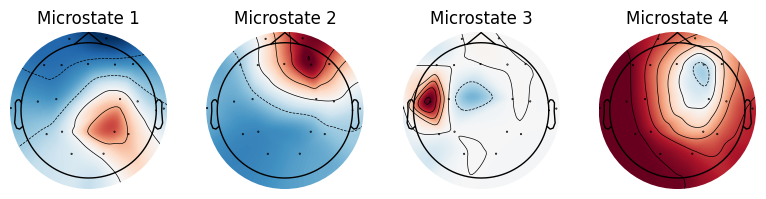

In [9]:
# visualize the maps.
from snn_lib.plots.microstate_plot import plot_maps
eeg_raw.rename_channels({ch_name: ch_name.replace("EEG ", "").replace("-Ref", "") for ch_name in eeg_raw.info['ch_names']})

eeg_raw.set_montage("standard_1020")
plot_maps(microstate_maps, eeg_raw.info, False)


In [10]:
import matplotlib.pyplot as plt
def plot_microstates(eeg_data, microstate_sequence, freq = 256, time_step_offsets = 0):
     color_map = {
        0: '#00FFFF',
        1: '#FF007F',
        2: '#00CC00',
        3: '#6666FF',
     }
     color_sequence = [color_map[m_id] for m_id in microstate_sequence]
     time_steps = eeg_data.shape[0]
     channels = eeg_data.shape[1]
     dt = 1 / freq
     t = np.arange(eeg_data.shape[0]) * dt
     time_duration = time_steps * dt
     plt.figure(figsize=(10, 8))
     for i in range(channels):
        plt.plot(t + time_step_offsets * dt, eeg_data[:, i] + 0.00015 * (i + 2), markersize=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Channels')

        plt.xlim(time_step_offsets * dt, time_step_offsets * dt + time_duration)
        plt.ylim(0.0, 0.002)
     plt.yticks(np.arange(0, 0.00375, 0.0001))
     plt.plot(t + time_step_offsets * dt, eeg_data[:, i] + 0.00015 * (i + 2), markersize=2)
     for index, _t in enumerate(t):
         plt.vlines(x=_t, ymin = 0, ymax = 0.00013, color = color_sequence[index])
         # plt.scatter(t + time_step_offsets * dt, [[0.0001]] * time_steps, c = color_sequence, s=1, marker = 's')

     

## Frequency Curve Construction

In [11]:
import matplotlib.pyplot as plt

In [12]:
# def calculate frequency density
def generate_frequency_density(eeg_data, seizure_onset_annotations, sampling_frequency = 256, \
                               left_decay_coefficiency = 0.4, right_decay_coefficiency = 0.4):
    time_steps = eeg_data.shape[0]
    frequency_density = np.zeros((time_steps))
    for seizure_onset_annotation in seizure_onset_annotations:
        seizure_onset_start_time_step = seizure_onset_annotation[0]
        seizure_onset_end_time_step = seizure_onset_annotation[1]
        frequency_density[seizure_onset_start_time_step: seizure_onset_end_time_step] = sampling_frequency
        time_step = seizure_onset_start_time_step
        while time_step >= 0:
            abs_delta = seizure_onset_start_time_step - time_step
            freq = np.exp(-1 * left_decay_coefficiency * (abs_delta / sampling_frequency)) * sampling_frequency
            frequency_density[time_step] = freq
            time_step -= 1

        time_step = seizure_onset_end_time_step
        while time_step < time_steps:
            abs_delta = time_step - seizure_onset_end_time_step
            freq = np.exp(-1 * right_decay_coefficiency * (abs_delta / sampling_frequency)) * sampling_frequency
            frequency_density[time_step] = freq
            time_step += 1
            
    return frequency_density

def calculate_spike_frequency_distribution_by_sliding_window(spikes_series, windows_size = 256, sampling_frequency = 256):
    time_steps = len(spikes_series)
    frequency_distribution = np.zeros((time_steps))
    cnt_spikes_in_windows = 0
    for t in range(time_steps):
        cnt_spikes_in_windows += spikes_series[t]
        if t < windows_size:
            freq = cnt_spikes_in_windows / windows_size
            frequency_distribution[t] = freq
            continue
        cnt_spikes_in_windows -= spikes_series[t - windows_size]
        freq = cnt_spikes_in_windows / windows_size
        frequency_distribution[t] = freq
        
    return frequency_distribution * sampling_frequency

def plot_frequency_density(frequency_density_data, sampling_frequency = 256):
    time_steps = frequency_density_data.shape[0]
    plt.plot(np.arange(0, time_steps) / sampling_frequency, frequency_density_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Temporal Frequency Distribution")


In [13]:
sampling_freq = 500

target_frequency_density_data = generate_frequency_density(train_data, [(seizure_offset, seizure_offset + seizure1_length)], sampling_frequency = sampling_freq)

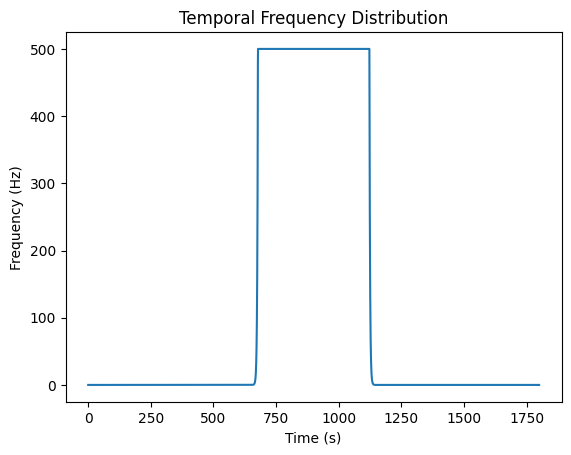

In [14]:
plot_frequency_density(target_frequency_density_data, sampling_frequency = sampling_freq)

## Spike Encoding

In [15]:
import matplotlib.pyplot as plt

In [16]:
cnt_microstates = 4

In [17]:
a = (train_data.dot(microstate_maps.T)) ** 2

In [18]:
microstate_sequence = np.argmax(a, axis = 1)

In [19]:
spikes = np.zeros((len(microstate_sequence), cnt_microstates))
for i in range(cnt_microstates):
    spikes[microstate_sequence == i, i] = 1

## Network Building

In [38]:
from snn_lib.neuron_models.leaky_intergrate_and_fire_model import *
from snn_lib.synapse_models.delay_connection import *

from snn_lib.synapse_models.exponential_synapse import *
from snn_lib.neuron_models.point_process_model import *
from snn_lib.connections.full_connection import *
from snn_lib.connections.possibility_connection import *
from snn_lib.connections.all_to_all_connection import *

from snn_lib.connections.one_to_one_connection import OneToOneConnection
from snn_lib.neuron_models.fixed_spike_train_neuron_model import FixedSpikeTrainNeuronModel
from snn_lib.monitors.neuron_monitors import NeuronOutputMonitor, NeuronMembranePotentialMonitor
from snn_lib.monitors.synapse_monitors import *
from snn_lib.monitors.network_recorder_manager import NetworkRecorderManager
from snn_lib.network.network_builder import NetworkBuilder
import numpy as np

from tqdm import tqdm

In [39]:
network_builder = NetworkBuilder()

### Build reservoir network (Population version)

In [40]:
n_reservior_neurons = 39
freq = 500
n_microstates = cnt_microstates
dt = 1 / freq
connection_possibility = 0.2
time_steps = len(microstate_sequence)
dummy_spikes = spikes # np.random.randint(0, 2, size=(n_microstates, int(time_steps)))

# Generate input neurons
input_neuron = network_builder.add_neuron(f'input', FixedSpikeTrainNeuronModel(N = n_microstates, spikes = dummy_spikes, hyperparameters = {'dt': dt}))

# Generate reservoir neurons
reservoir_neuron = network_builder.add_neuron(f'reservoir', CurrentBasedLIFNeuron(n_reservior_neurons, {'dt': dt}))

# Generate output neurons
output_neuron = network_builder.add_neuron('output', CurrentBasedLIFNeuron(1, {'dt': dt}))

# Connection: inner reservoir.
network_builder.add_connection((f'reservoir', f'reservoir', PossibilityConnection(reservoir_neuron, reservoir_neuron, connection_possibility), \
                                DoubleExponentialSynapse(pre_N = 39, post_N = 39, dt = dt, td = 1e-2, tr = 5e-3)))

# Connection: reservoir -> output.
network_builder.add_connection((f'reservoir', f'output', AllToAllConnection(reservoir_neuron, output_neuron), DoubleExponentialSynapse(39, 1,  dt = dt, td = 1e-2, tr = 5e-3)))

# Connection: input -> reservoir.
network_builder.add_connection((f'input', f'reservoir', CustomConnection(input_neuron, reservoir_neuron, [[0, 1, 2, 3], [0, 1, 2, 3]]), DoubleExponentialSynapse(4, 39, dt = dt, td = 1e-2, tr = 5e-3)))

,
def sigmoid(x):
  try:
      exp_x = np.exp(-x)
  except OverflowError:
      print(-x)
  return 1 / (1 + exp_x)

def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
network = network_builder.build_network()
network.initialize_network()

# ------------------------------------------- Begin Build records -------------------------------------------
def recalculate_spikes_in_window(t, recorder, neuron, neuron_id, current_record):
    new_value = current_record + recorder.get_neuron_recorder("neuron_spike_series")[neuron_id][t]
    
    if t < windows_size:
        return new_value
    else:
        new_value -= recorder.get_neuron_recorder('neuron_spike_series')[neuron_id][t - windows_size]
        return new_value

def part_S_c_i_part_w_ij(t, recorder, connection, current_record):
    if connection[0] != 'reservoir' or connection[1] != 'output':
        return []
    pre_neuron = recorder.neuron_map[connection[0]]
    new_record = current_record + [np.zeros(pre_neuron.n_neuron)]
    if t < 0:
        raise ValueError
    if t == 0:
        return new_record
    if t > 0 and t <= windows_size:
        syapse_output_from_pre_neuron = connection[3]._states[connection[3]._output_index]
        post_neuron_id = connection[1]

        # post_neuron_potential need divide 1000, converting from mV to V.
        post_neuron_potential = recorder.get_neuron_recorder('neuron_mebrance_potential')[post_neuron_id][t] / 1000
        new_record[-1] = new_record[t - 1] + sigmoid(post_neuron_potential / 1000) * syapse_output_from_pre_neuron
        return new_record
    if t > windows_size:
        syapse_output_from_pre_neuron = connection[3]._states[connection[3]._output_index]
        post_neuron_id = connection[1]
        post_neuron_potential = recorder.get_neuron_recorder('neuron_mebrance_potential')[post_neuron_id][t]
        new_record[-1] = new_record[t - 1] + sigmoid(post_neuron_potential / 1000) * (syapse_output_from_pre_neuron - new_record[t - windows_size])
        return new_record
    
train_recorder = NetworkRecorderManager(network.neurons, network.connections)
windows_size = 500
train_recorder.add_neuron_recorder('neuron_spike_series',  lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron._output_index]])
train_recorder.add_neuron_recorder('neuron_freq_series', lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [recorder.get_neuron_recorder('cnt_spikes_in_window_record')[neuron_id] / windows_size])
train_recorder.add_neuron_recorder('neuron_mebrance_potential', lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron.INDEX_V]])
train_recorder.add_connection_recorder('connection_history_weights', lambda : [], \
                                   lambda t, recorder, connection, current_record, arg: current_record + [connection[2].W])
train_recorder.add_neuron_recorder('cnt_spikes_in_window_record', lambda : 0, \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: recalculate_spikes_in_window(t, recorder, neuron, neuron_id, current_record))

train_recorder.add_connection_recorder('part_S_c-i_part_w_ij', lambda: [], \
                                   lambda t, recorder, connection, current_record, arg: part_S_c_i_part_w_ij(t, recorder, connection, current_record))



train_recorder.add_pre_requisite(record="cnt_spikes_in_window_record", requisite=[(NetworkRecorderManager.NEURON_RECORD, 'neuron_spike_series')])
train_recorder.add_pre_requisite(record="neuron_freq_series", requisite=[(NetworkRecorderManager.NEURON_RECORD, 'cnt_spikes_in_window_record')])
train_recorder.add_pre_requisite(record="part_S_c-i_part_w_ij", \
                                 requisite=[(NetworkRecorderManager.NEURON_RECORD, 'neuron_mebrance_potential'), \
                                            (NetworkRecorderManager.NEURON_RECORD, 'neuron_spike_series'), \
                                            (NetworkRecorderManager.CONNECTION_RECORD, 'connection_history_weights')
                                           ])

                                   
train_recorder.initialize_recorders()
# ------------------------------------------- End Build records -------------------------------------------


In [41]:
cost = 0
r = 0.01 # learning rate
train_connections = []
for connection in network.connections:
    if(connection[0].startswith('r') and connection[1] == 'output'):
        train_connections.append(connection)

part_s_c_i_part_w_recorder = train_recorder.get_connection_recorder('part_S_c-i_part_w_ij')
frequency_output_recorder = train_recorder.get_neuron_recorder('neuron_freq_series')

time_steps = 10
for t in tqdm(range(time_steps)):
        network.forward_single_time_step(t, train_recorder)
        # update weights
        # 1. retrieve necessary records.\n",
        frequency_output = frequency_output_recorder['output'][t]
        for connection in train_connections:
            # print(part_s_c_i_part_w_recorder[connection[0] + '_output'],connection[0] + '_output')
            part_s_c_i_part_w_record = part_s_c_i_part_w_recorder[connection[0] + '_output'][t]
            part_F_part_w = (1 / windows_size) * part_s_c_i_part_w_record
            freq_diff = frequency_output - target_frequency_density_data[t] / freq
            surrogate_gradient = (freq_diff * part_F_part_w).clip(50) # gradient clip
            # update weight
            # if (surrogate_gradient != 0):
            #     #print(\"update [%s], W += \" % (connection[0] + '_output'), r * surrogate_gradient)\n",
            #     connection[2].W += r * surrogate_gradient
        cost += 0.5 * (frequency_output - target_frequency_density_data[t] / freq) ** 2
print("End of an epoch, cost = %lf" % (cost))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 113.33it/s]

last v = [-60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.
 -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.
 -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.]
new v = [-60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.
 -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.
 -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.]
self.vthr = -50, s = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
last v = [-60.]
new v = [-60.]
self.vthr = -50, s = [0]
neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001F05EDDFD90> update state to [array([0., 0., 0., 1.]), 1, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001F05E1033D0> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


C:\Users\Micro\AppData\Local\Temp\ipykernel_3788\1235628661.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("End of an epoch, cost = %lf" % (cost))


In [42]:
train_recorder.neuron_recorders['neuron_spike_series'].record

{'input': [array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.])],
 'reservoir': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0

In [43]:
train_recorder.neuron_recorders['neuron_mebrance_potential'].record

{'input': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'reservoir': [array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60.]),
  array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60.]),
  array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
         -60., -60., -60., -60., -60., -60.]),
  array([-60.        , -58.48631835, -58.37027876, -60.        ,
         -60.        , -60.        , -60.        , -60.        ,

In [44]:
train_recorder.recorders['neuron_mebrance_potential")

SyntaxError: EOL while scanning string literal (3602180512.py, line 1)

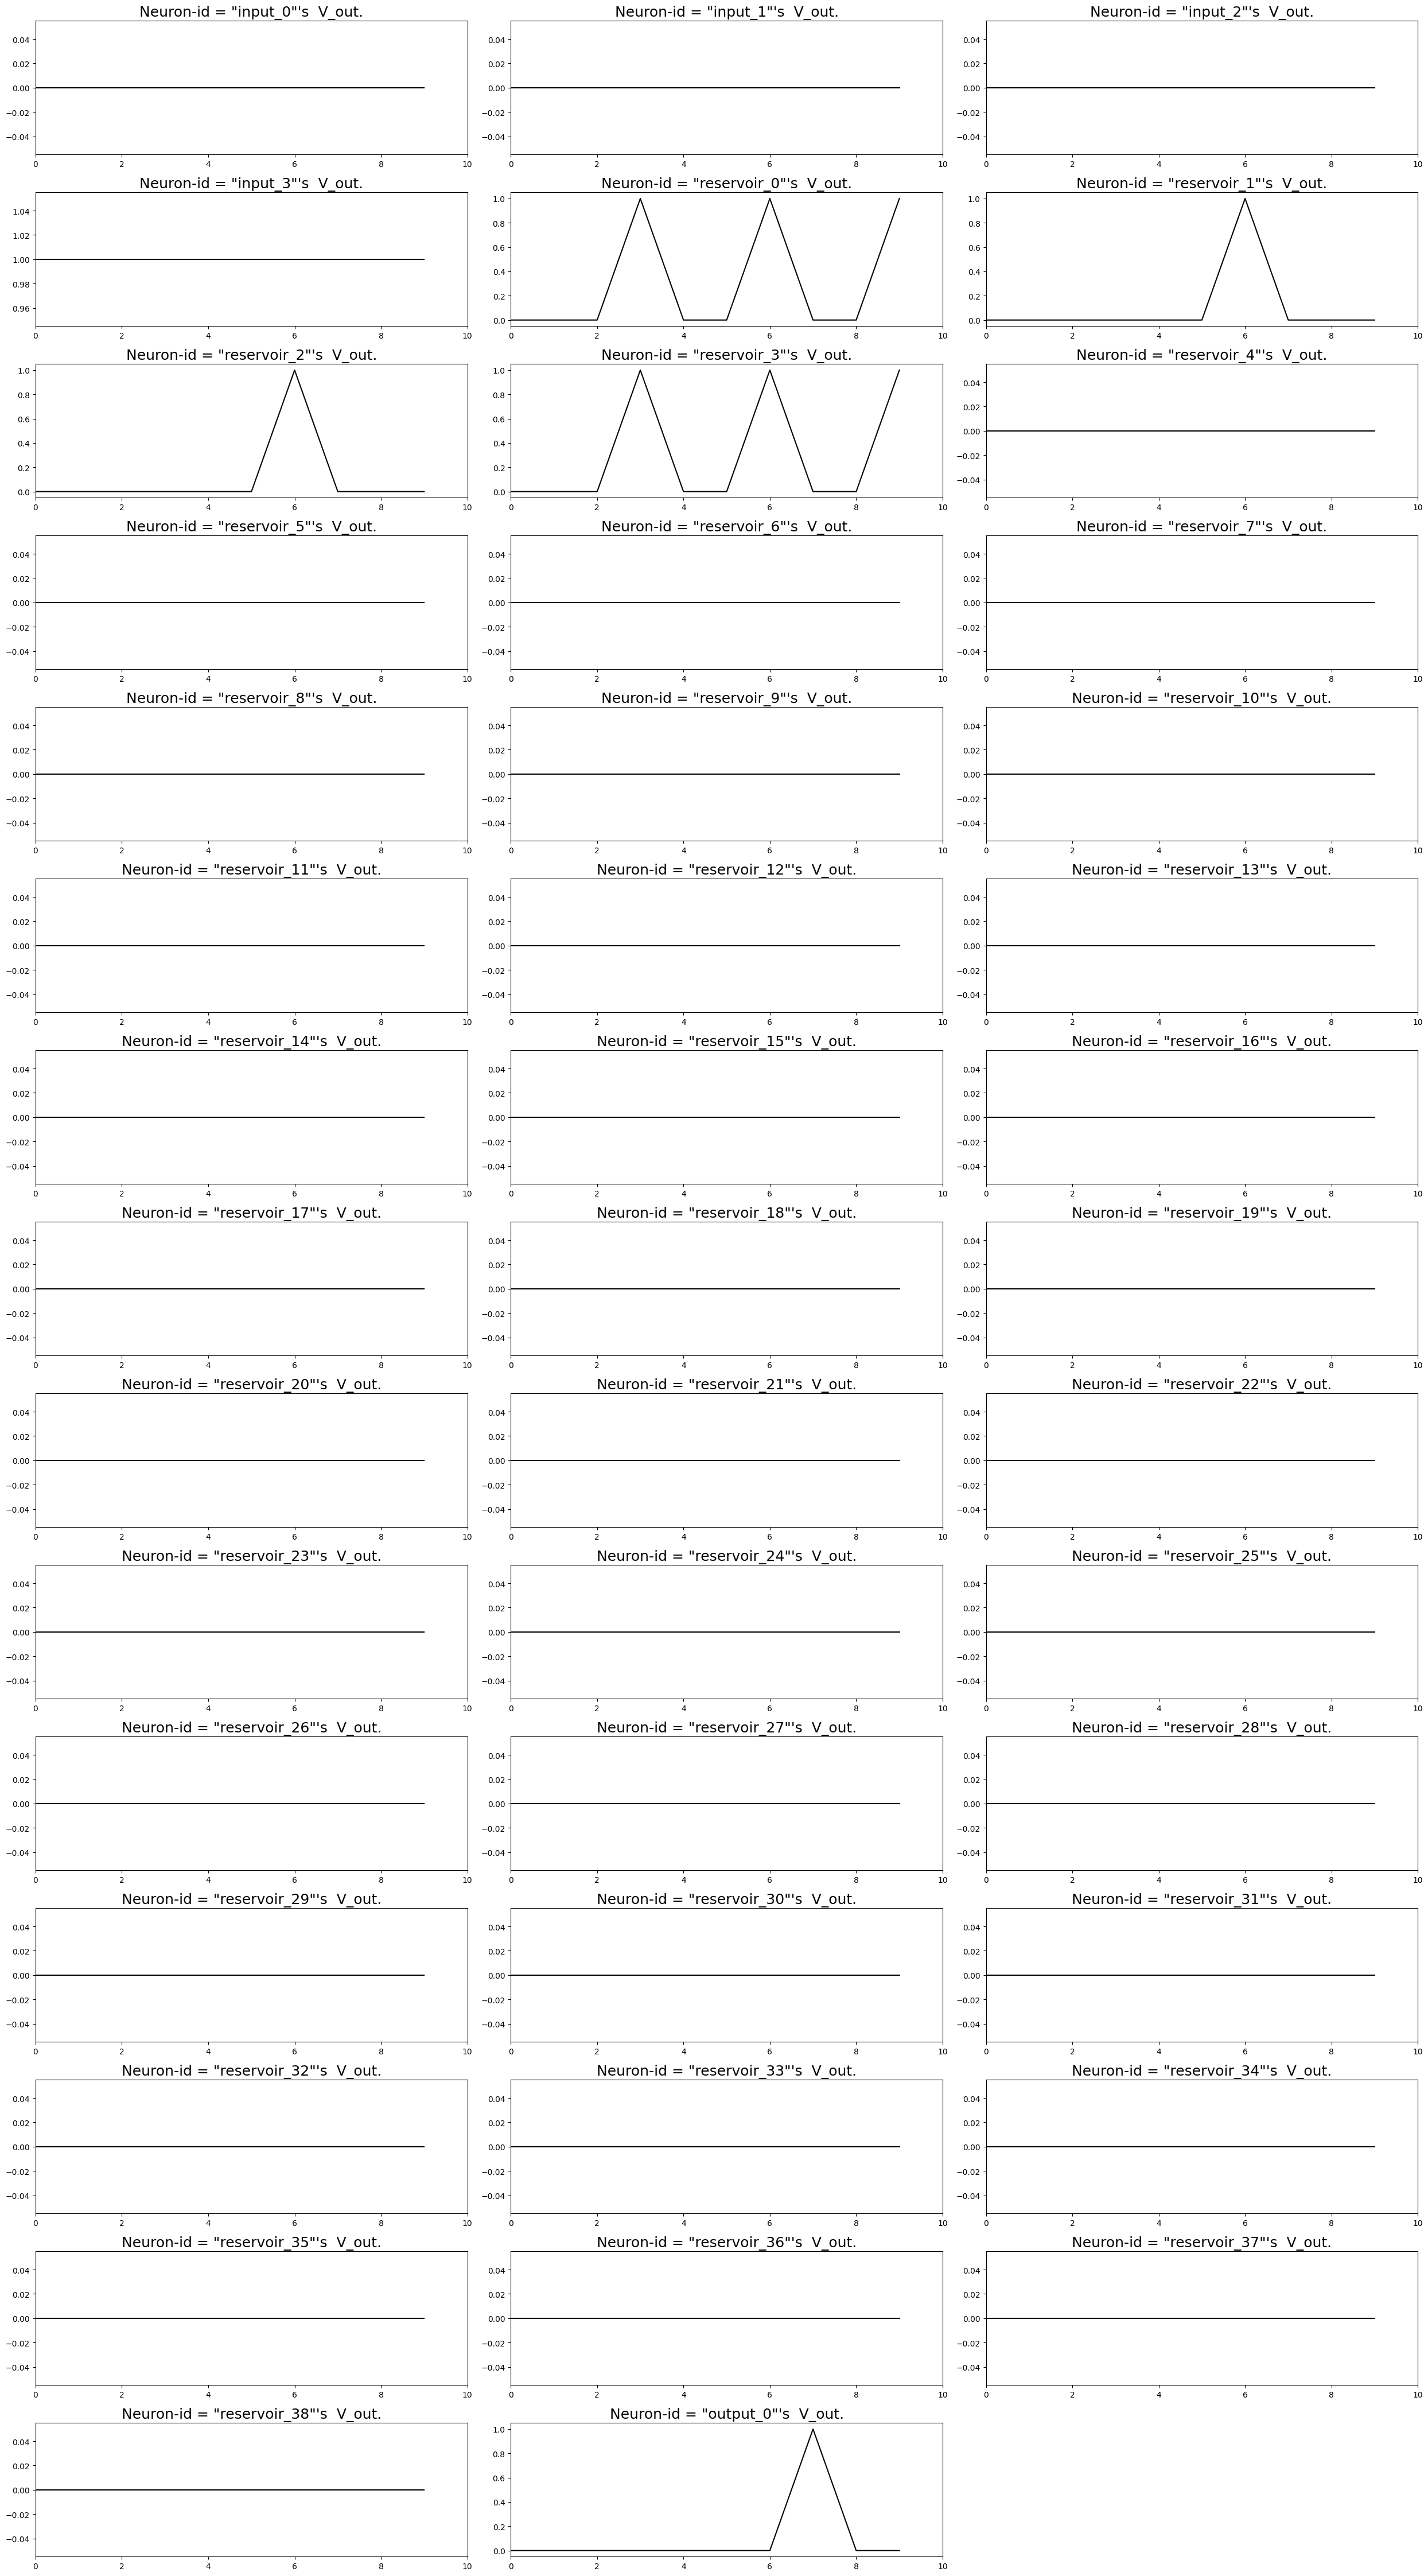

In [45]:
plot_neuron_record(train_recorder, 'neuron_spike_series', lambda record_id, i: 'Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  V_out.')

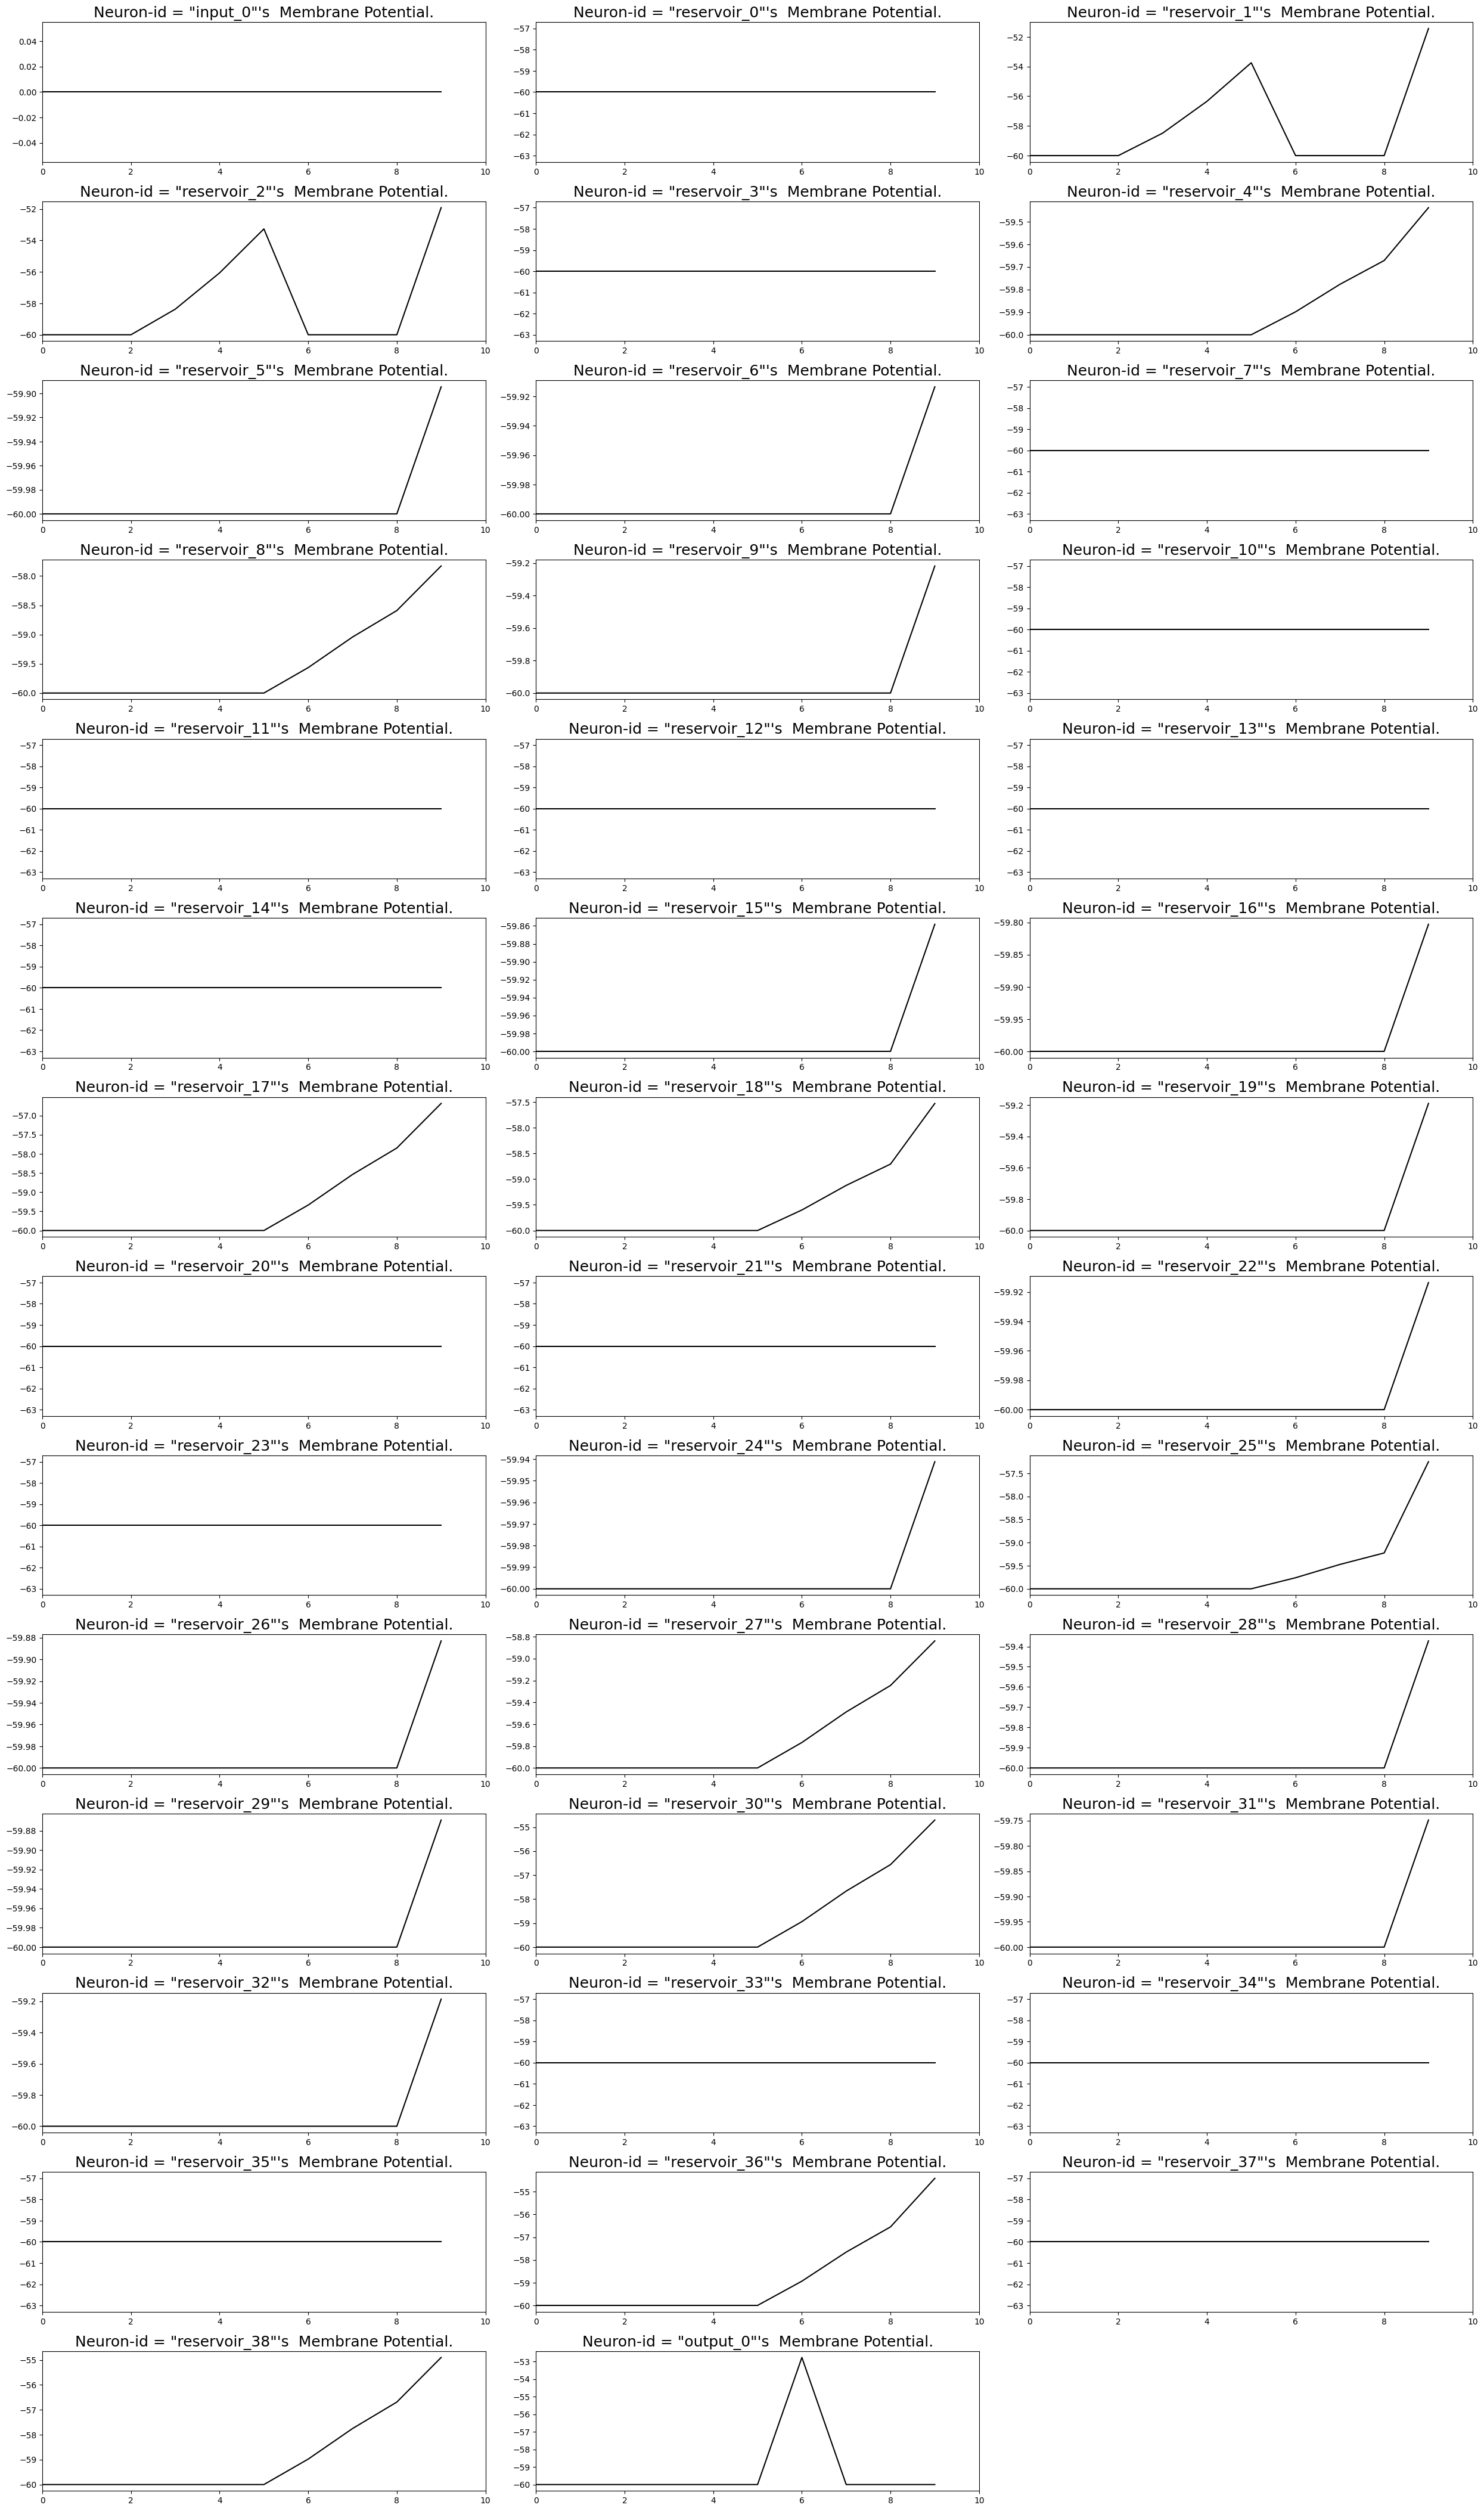

In [46]:
plot_neuron_record(train_recorder, 'neuron_mebrance_potential', lambda record_id, i: 'Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  Membrane Potential.')

In [31]:
neuron_output_record = network.neuron_output_monitor.get_dataframe_record()


In [ ]:
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(25,45))
rows = int(np.ceil(sum([network.neurons[n].n_neuron for n in network.neurons]) / 3))
cols = 3
current_index = 0
for record_id in neuron_output_record:
    record = (np.array([list(r) if hasattr(r, '__iter__') else [r] for r in neuron_output_record[record_id]]))
    for i in range(record.shape[1]):
        plt.subplot(rows, cols, current_index + 1)
        plt.tight_layout()
    
        plt.plot(np.arange(int(time_steps) + 1)[:time_steps + 1] * dt, record[:, i] , color="k")
        plt.xlim(0, time_steps * dt)
        plt.xlabel('$time$ ($s$)')
        plt.ylabel('$V$ ($mV$)')
        plt.title('Neuron-id = "' + record_id + ('_%d' % i) + '"\'s Output Voltage.', fontsize = 18)
        current_index += 1

In [ ]:
neuron_membrane_potential = network.neuron_membrane_potential_monitor.get_dataframe_record()

In [ ]:
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(25,45))
rows = int(np.ceil(sum([network.neurons[n].n_neuron for n in network.neurons]) / 3))
cols = 3
current_index = 0
for record_id in neuron_membrane_potential:
    record = (np.array([list(r) if hasattr(r, '__iter__') else [r] for r in neuron_membrane_potential[record_id]]))
    for i in range(record.shape[1]):
        plt.subplot(rows, cols, current_index + 1)
        plt.tight_layout()
    
        plt.plot(np.arange(int(time_steps) + 1)[:time_steps + 1] * dt, record[:, i] , color="k")
        plt.xlim(0, time_steps * dt)
        plt.xlabel('$time$ ($s$)')
        plt.ylabel('$V$ ($mV$)')
        plt.title('Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  Membrane Potential.', fontsize = 18)
        current_index += 1



In [ ]:
output_spike_train = np.array(neuron_output_record['output'])
output_frequency_distribution = calculate_spike_frequency_distribution_by_sliding_window(output_spike_train, windows_size = 500, sampling_frequency = 500)


In [ ]:
plot_frequency_density(output_frequency_distribution, sampling_frequency = sampling_freq)

In [ ]:
plt.plot(output_spike_train)

In [ ]:
plot_frequency_density(target_frequency_density_data, sampling_frequency = sampling_freq)

In [ ]:

output_spike_train = np.array(neuron_output_record['output'])


In [ ]:
np.zeros((39, 4)).sum(axis=1)

array([[1., 1.]])